In [ ]:
!pip3 install beautifulsoup4
!pip3 install requests
!pip install iseaborn

### SpaceX Falcon 9 first stage Landing Prediction

In [2]:
import sys

import requests
import pandas as pd
import numpy as np
import datetime
from bs4 import BeautifulSoup
import re
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### Request to the SpaceX API

In [3]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response_s = requests.get(spacex_url)

static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'
response=requests.get(static_json_url)

In [4]:
data = pd.json_normalize(response.json())
data.head()

,static_fire_date_utc,static_fire_date_unix,tbd,net,window,rocket,success,details,crew,ships,capsules,payloads,launchpad,auto_update,failures,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,True,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,https://images2.imgbox.com/40/e3/GypSkayF_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,"Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,True,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]",2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,True,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/3d/86/cnu0pan8_o.png,https://images2.imgbox.com/4b/bd/d8UxLh4q_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,True,"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,True,[],4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_succes

In [5]:
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]
data.head()

,rocket,payloads,launchpad,cores,flight_number,date_utc
0,5e9d0d95eda69955f709d1eb,[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",1,2006-03-24T22:30:00.000Z
1,5e9d0d95eda69955f709d1eb,[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",2,2007-03-21T01:10:00.000Z
2,5e9d0d95eda69955f709d1eb,"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",3,2008-08-03T03:34:00.000Z
3,5e9d0d95eda69955f709d1eb,[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",4,2008-09-28T23:15:00.000Z
4,5e9d0d95eda69955f709d1eb,[5eb0e4b7b6c3bb0006eeb1e6],5e9e4502f5090995de566f86,"[{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5,2009-07-13T03:35:00.000Z


Removing rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket

In [6]:
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])
data['date'] = pd.to_datetime(data['date_utc']).dt.date
data = data[data['date'] <= datetime.date(2020, 11, 13)]

The data from these requests will be stored in lists and will be used to create a new dataframe.

In [7]:
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [8]:
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])



In [9]:
getBoosterVersion(data)
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [10]:
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

In [11]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [12]:
df = pd.DataFrame(launch_dict)
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [13]:
data_falcon9 = df[df['BoosterVersion'] == 'Falcon 9']
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [14]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


In [15]:
data_falcon9.isnull().sum()

,0
FlightNumber,0
Date,0
BoosterVersion,0
PayloadMass,5
Orbit,0
LaunchSite,0
Outcome,0
Flights,0
GridFins,0
Reused,0


In [16]:
PayloadMassMean = data_falcon9['PayloadMass'].mean()
data_falcon9.replace(np.nan, PayloadMassMean, inplace=True)
data_falcon9.head()


/tmp/ipython-input-16-3027243635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9.replace(np.nan, PayloadMassMean, inplace=True)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,6123.547647,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,6123.547647,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,6123.547647,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,6123.547647,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,6123.547647,1.0,0,B1004,-80.577366,28.561857


In [17]:
data_falcon9.to_csv('dataset_part_1.csv', index=False)

### Collect Falcon 9 historical launch records from a Wikipedia page titled List of Falcon 9 and Falcon Heavy launches

In [18]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()

    colunm_name = ' '.join(row.contents)

    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name

In [19]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

In [20]:
response_wiki = requests.get(static_url)
soup = BeautifulSoup(response_wiki.text)
print(soup.title)

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


In [21]:
html_tables = soup.find_all('table')
first_launch_table = html_tables[2]
column_names = []
first_launch_table_header = first_launch_table.find_all('th')

for th in first_launch_table_header:
    name = extract_column_from_header(th)
    if name is not None and len(name) > 0:
        column_names.append(name)

print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


In [22]:
launch_dict= dict.fromkeys(column_names)


del launch_dict['Date and time ( )']


launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []

launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [24]:
extracted_row = 0
#Extract each table
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element
        row=rows.find_all('td')
        #if it is number save cells in a dictonary
        if flag:
            extracted_row += 1
            launch_dict["Flight No."].append(flight_number)
            # print(flight_number)

            datatimelist=date_time(row[0])
            launch_dict["Date"].append(datatimelist)
            date = datatimelist[0].strip(',')
            # print(date)

            time = datatimelist[1]
            launch_dict["Time"].append(time)
            # print(time)

            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            # print(bv)
            launch_dict["Version Booster"].append(bv)

            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)
            # print(launch_site)

            payload = row[3].a.string
            launch_dict["Payload"].append(payload)
            # print(payload)


            payload_mass = get_mass(row[4])
            launch_dict["Payload mass"].append(payload_mass)
            # print(payload_mass)

            orbit = row[5].a.string
            launch_dict["Orbit"].append(orbit)
            # print(orbit)

            customer_tag = row[6].a
            if customer_tag is not None:
                customer = customer_tag.string
            else:
                customer = "Unknown"
            launch_dict["Customer"].append(customer)
            # print(customer)

            launch_outcome = list(row[7].strings)[0]
            launch_dict["Launch outcome"].append(launch_outcome)
            # print(launch_outcome)

            booster_landing = landing_status(row[8])
            launch_dict["Booster landing"].append(booster_landing)
            # print(booster_landing)

In [25]:
for key, value in launch_dict.items():
    if not isinstance(value, list):
        launch_dict[key] = [value]
max_length = max(len(v) for v in launch_dict.values())

# Pad shorter lists with None
for key in launch_dict:
    while len(launch_dict[key]) < max_length:
        launch_dict[key].append(None)

# Now create the DataFrame
df = pd.DataFrame(launch_dict)
df.to_csv('spacex_web_scraped.csv', index=False)
df.head()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.07B0003.18,Failure,"[4 June 2010,, 18:45]",18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.07B0004.18,Failure,"[8 December 2010,, 15:43]",15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.07B0005.18,No attempt\n,"[22 May 2012,, 07:44]",07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.07B0006.18,No attempt,"[8 October 2012,, 00:35]",00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.07B0007.18,No attempt\n,"[1 March 2013,, 15:10]",15:10


In [26]:
data_falcon9['LaunchSite'].value_counts()


,count
LaunchSite,
CCSFS SLC 40,55
KSC LC 39A,22
VAFB SLC 4E,13


In [27]:
landing_outcomes = data_falcon9['Outcome'].value_counts()
landing_outcomes

,count
Outcome,
True ASDS,41
None None,19
True RTLS,14
False ASDS,6
True Ocean,5
False Ocean,2
None ASDS,2
False RTLS,1


True Ocean means the mission outcome was successfully landed to a specific region of the ocean while False Ocean means the mission outcome was unsuccessfully landed to a specific region of the ocean. True RTLS means the mission outcome was successfully landed to a ground pad False RTLS means the mission outcome was unsuccessfully landed to a ground pad.True ASDS means the mission outcome was successfully landed to a drone ship False ASDS means the mission outcome was unsuccessfully landed to a drone ship. None ASDS and None None these represent a failure to land.

In [28]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [29]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

element is zero if the corresponding row in Outcome is in the set bad_outcome; otherwise, it's one

In [30]:
data_falcon9['landing_class'] = data_falcon9['Outcome'].apply(lambda x: 0 if x in bad_outcomes else 1)
data_falcon9[['landing_class']].head(10)

,landing_class
4,0
5,0
6,0
7,0
8,0
9,0
10,1
11,1
12,0
13,0


In [31]:
data_falcon9['landing_class'].mean()


np.float64(0.6666666666666666)

In [32]:
data_falcon9.to_csv("dataset_part_2.csv", index=False)

relationship between Flight Number and Payload Mass

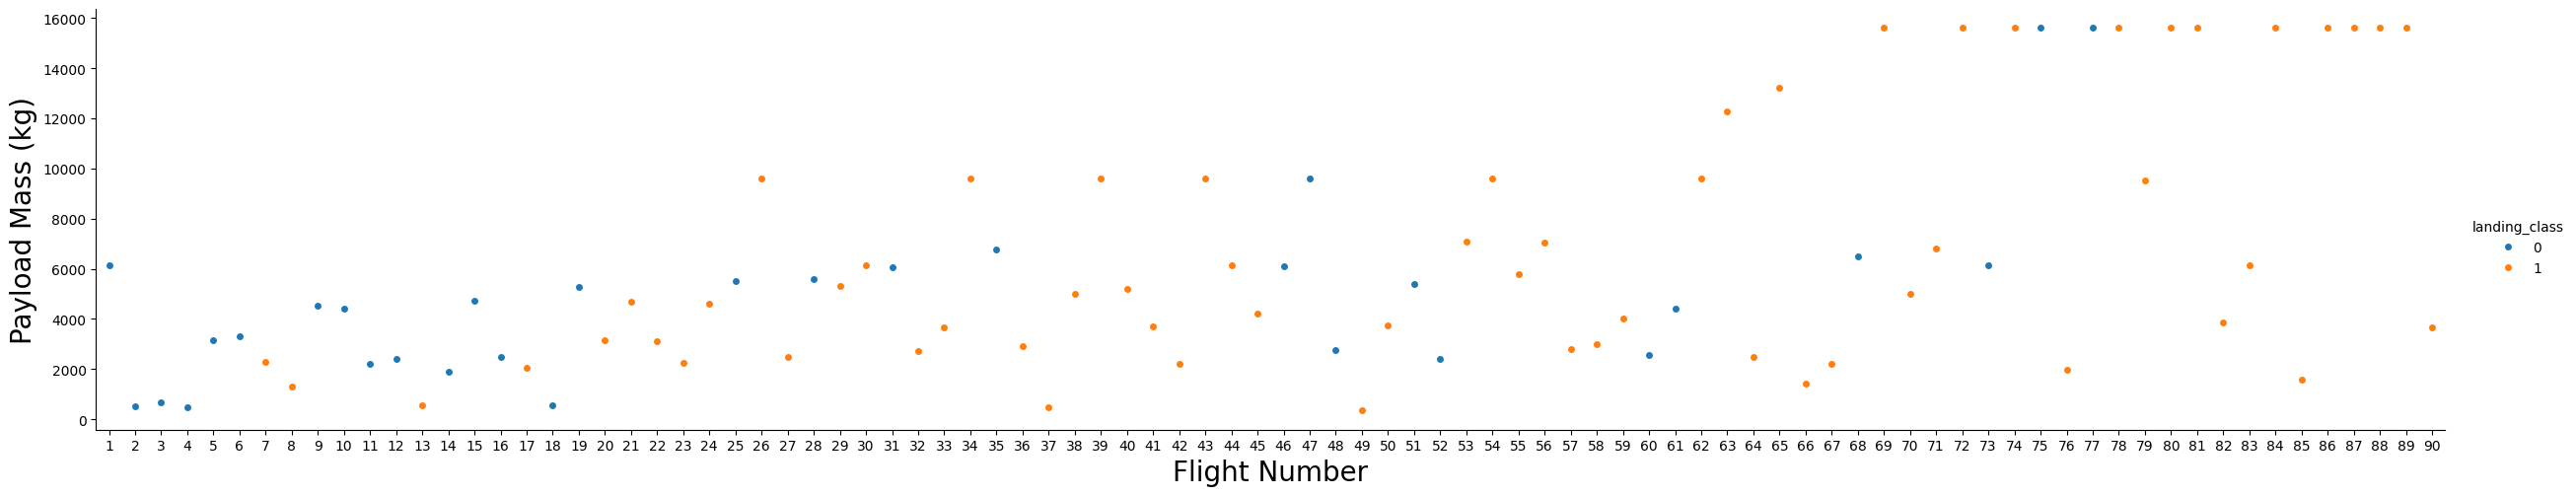

In [33]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue='landing_class', data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Payload Mass (kg)",fontsize=20)
plt.show()

relationship between Flight Number and Launch Site

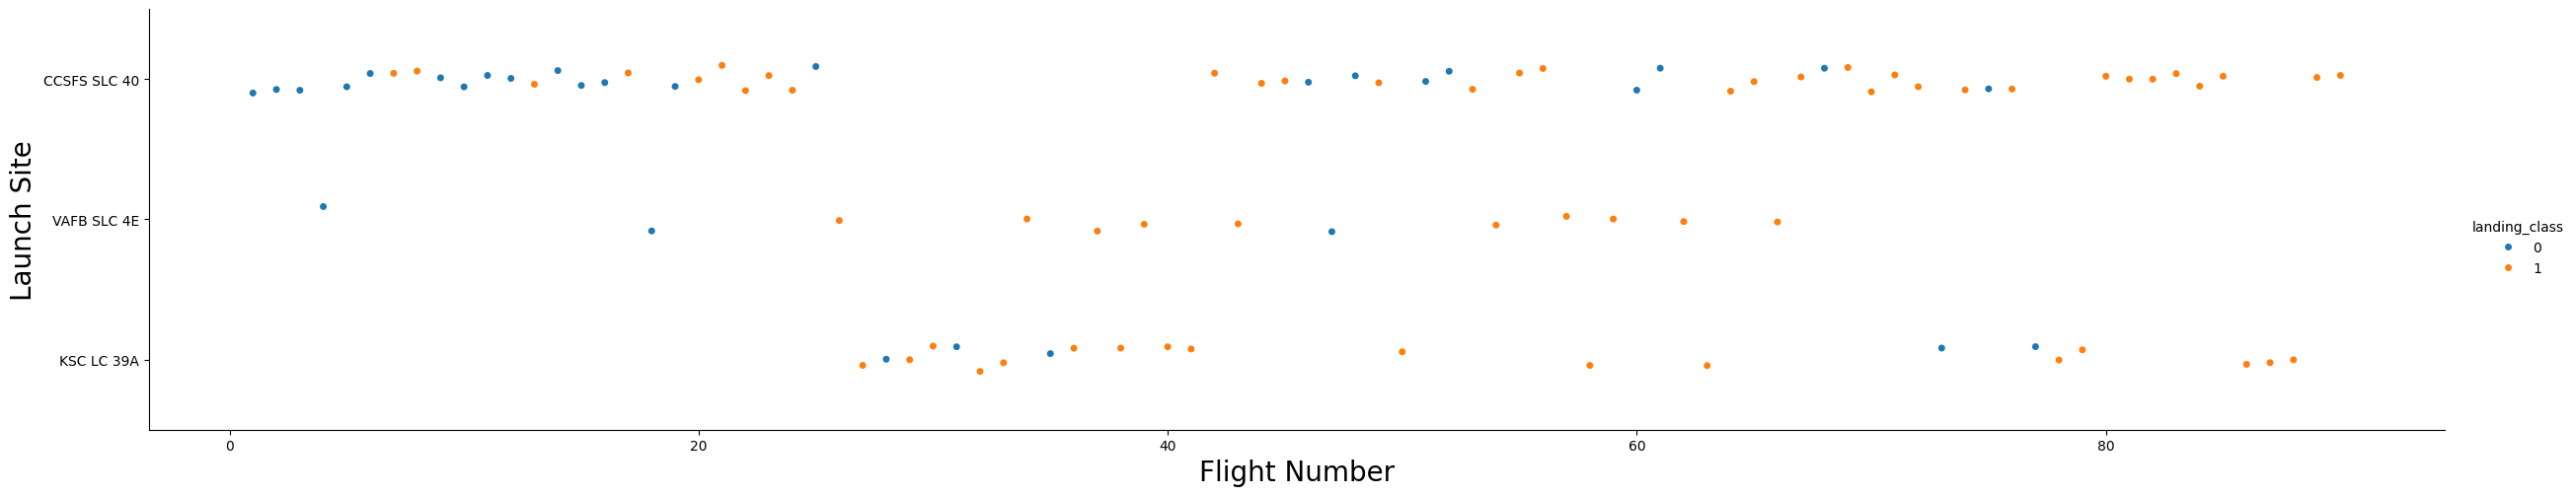

In [34]:
sns.catplot(y="LaunchSite", x="FlightNumber", hue='landing_class', data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

relationship between Payload Mass and Launch Site

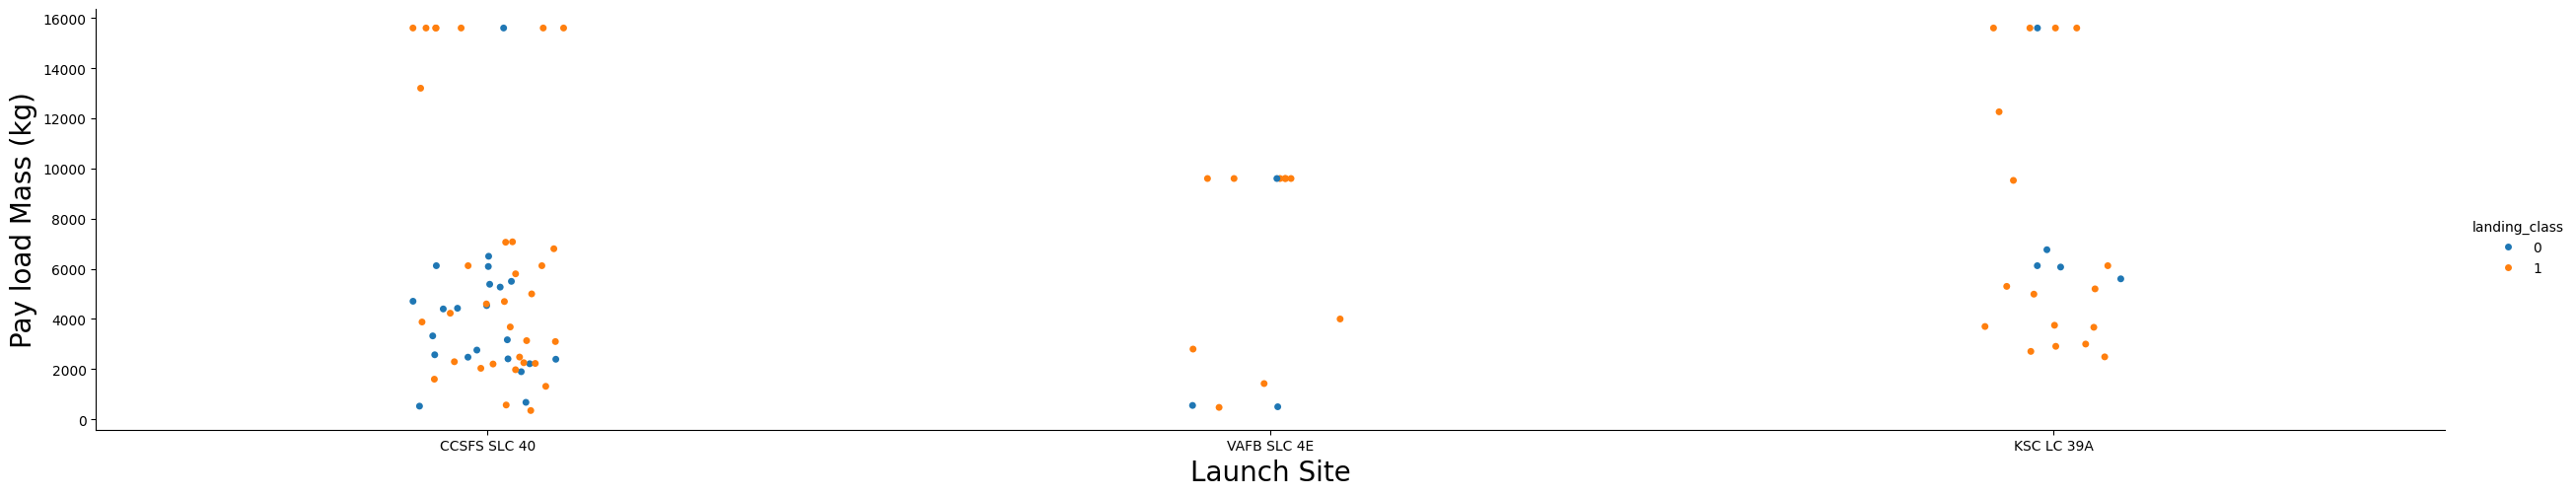

In [35]:
sns.catplot(y="PayloadMass", x="LaunchSite", hue='landing_class', data=data_falcon9, aspect = 5)
plt.xlabel("Launch Site",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

relationship between success rate of each orbit type

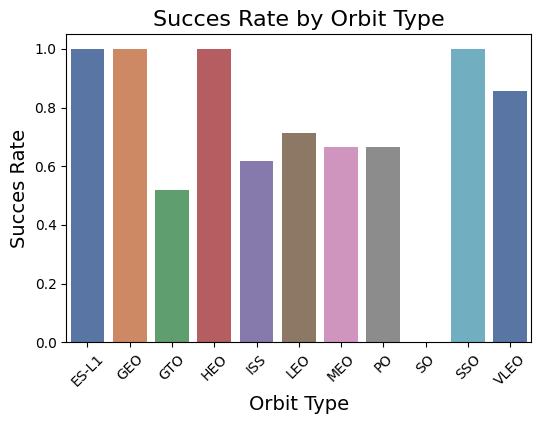

In [36]:
orbitdf = data_falcon9.groupby("Orbit")['landing_class'].mean()
orbitdf = orbitdf.to_frame().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x="Orbit", y='landing_class', hue="Orbit", data=orbitdf, palette="deep", legend=False)

plt.xlabel("Orbit Type", fontsize=14)
plt.ylabel("Succes Rate", fontsize=14)
plt.title("Succes Rate by Orbit Type", fontsize=16)

plt.xticks(rotation=45)
plt.show()

relationship between FlightNumber and Orbit type

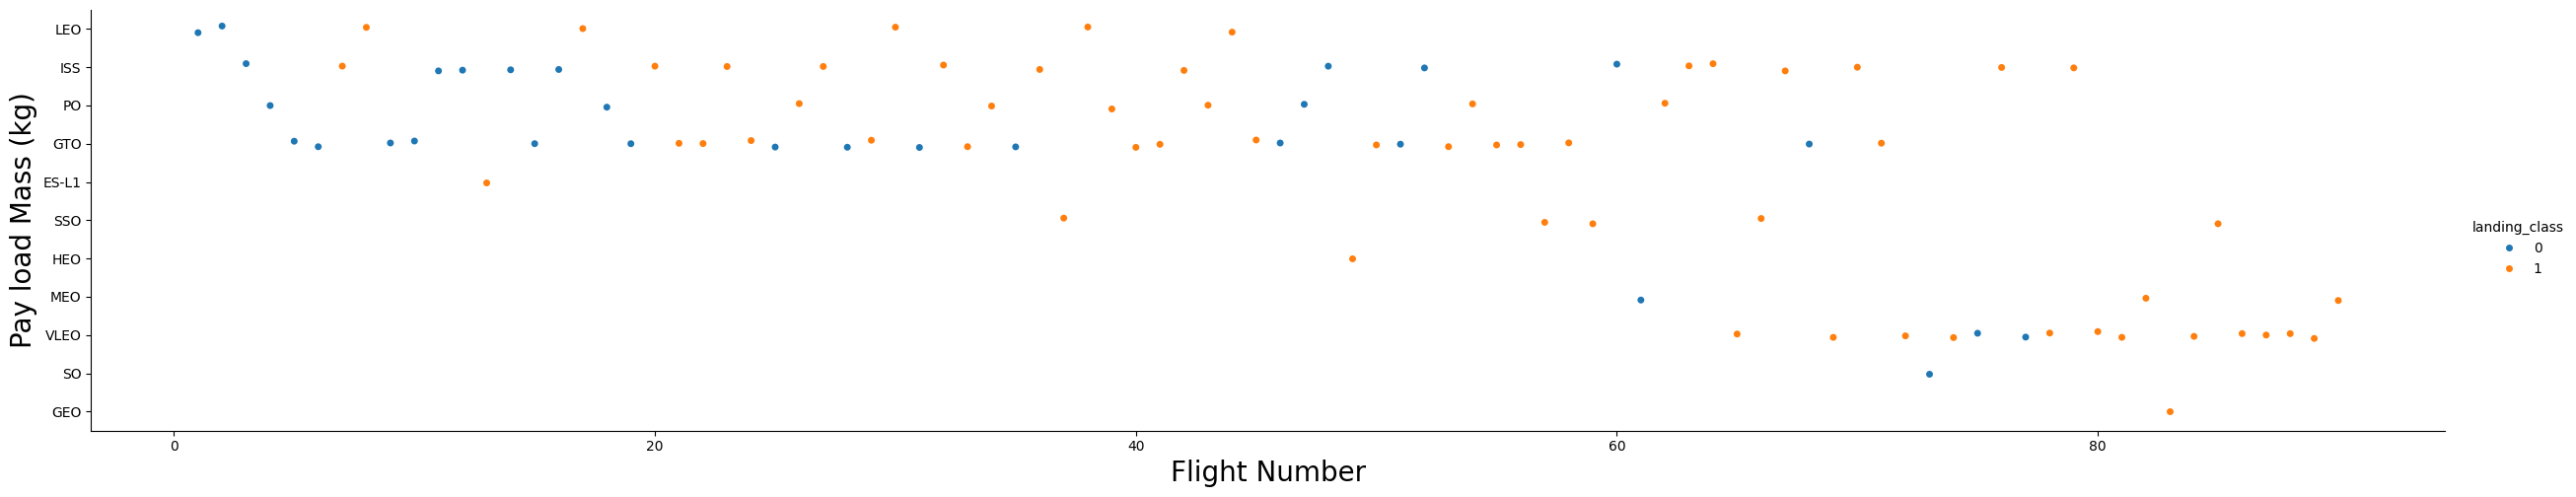

In [37]:
sns.catplot(y="Orbit", x="FlightNumber", hue='landing_class', data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

relationship between Orbit and PayloadMass

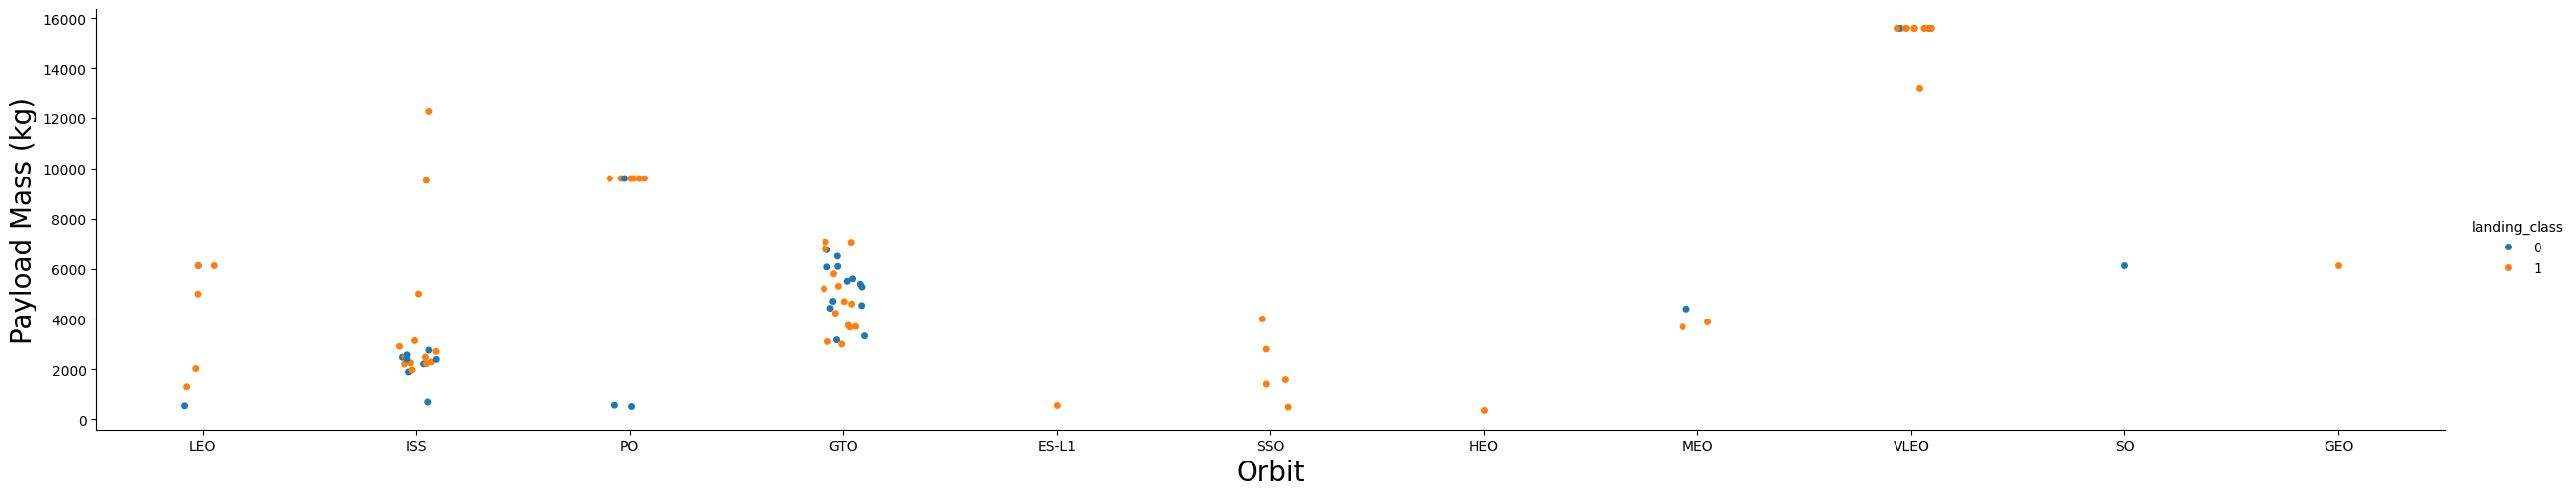

In [38]:
sns.catplot(x="Orbit", y="PayloadMass", hue='landing_class', data=data_falcon9, aspect = 5)
plt.xlabel("Orbit",fontsize=20)
plt.ylabel("Payload Mass (kg)",fontsize=20)
plt.show()

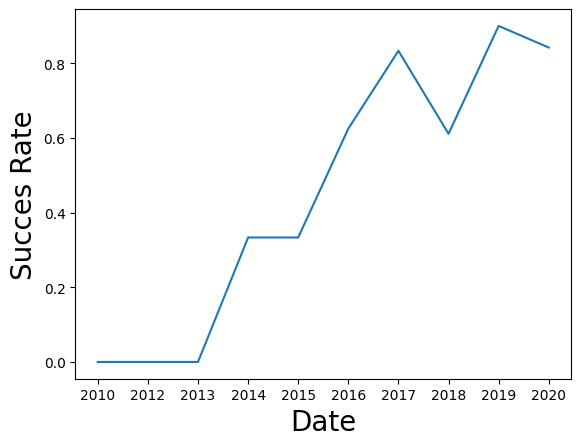

In [39]:
# A function to Extract years from the date
year=[]
year_data_falcon9 = data_falcon9
def Extract_year():
    for i in data_falcon9["Date"]:
        year.append(str(i).split("-")[0])
    return year
Extract_year()
year_data_falcon9['Date'] = year


yeardf = year_data_falcon9.groupby("Date")["landing_class"].mean()
yeardf = yeardf.to_frame().reset_index()

sns.lineplot(x="Date", y='landing_class', data=yeardf)
plt.xlabel("Date",fontsize=20)
plt.ylabel("Succes Rate",fontsize=20)
plt.show()

In [40]:
features = year_data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,6123.547647,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,6123.547647,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,6123.547647,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,6123.547647,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,6123.547647,1.0,0,B1004


### Preparing for ML

In [41]:
features_one_hot = pd.get_dummies(features[['Orbit','LaunchSite','LandingPad','Serial']])
features_one_hot = features_one_hot.astype(int)
features_one_hot.head()

,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_6123.547647058824,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
features_one_hot.to_csv('dataset_part_3.csv', index=False)

In [43]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [44]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

In [46]:
X = features_one_hot
Y = data_falcon9["landing_class"].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [47]:
transform = preprocessing.StandardScaler()
transform.fit(X)
X_scaled = transform.transform(X)
X_scaled

array([[-0.10599979, -0.10599979, -0.65465367, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-0.10599979, -0.10599979, -0.65465367, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-0.10599979, -0.10599979, -0.65465367, ..., -0.21566555,
        -0.18569534, -0.10599979],
       ...,
       [-0.10599979, -0.10599979, -0.65465367, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-0.10599979, -0.10599979, -0.65465367, ..., -0.21566555,
         5.38516481, -0.10599979],
       [-0.10599979, -0.10599979, -0.65465367, ..., -0.21566555,
        -0.18569534,  9.43398113]])

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 2, test_size = 0.2)
Y_test.shape

(18,)

Adding GridSearchCV to logistic regression helps to automatically find the best combination of hyperparameters

In [55]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression(max_iter=1000)
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [56]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8089285714285713


In [57]:
accuracy = logreg_cv.score(X_test, Y_test)
print("Test accuracy:", accuracy)

Test accuracy: 0.8333333333333334


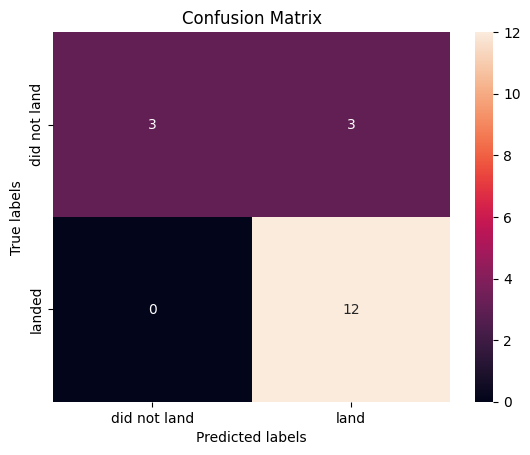

In [58]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes. The problem is false positives.

Overview:

True Positive - 12

False Positive - 3



In [59]:
parameters = {'kernel':('linear', 'rbf','poly', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [60]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': np.float64(1.0), 'gamma': np.float64(0.001), 'kernel': 'linear'}
accuracy : 0.8232142857142858


In [61]:
svm_cv.fit(X_test, Y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

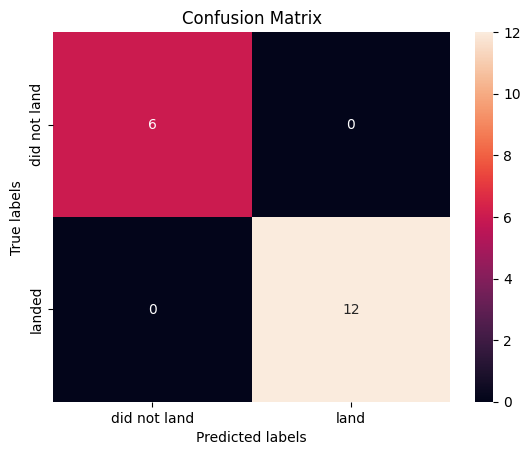

Test accuracy: 1.0


In [63]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
accuracy = svm_cv.score(X_test, Y_test)
print("Test accuracy:", accuracy)

We could observe that SVM predicts much better, this model can be choosen for our dataset